## Importing of Necessary Liberaries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ruptures as rpt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Reading data
df = pd.read_csv('../data/processed/processed_brent_oil_prices.csv')

In [3]:
df

,date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9006,2022-11-08,96.85
9007,2022-11-09,93.05
9008,2022-11-10,94.25
9009,2022-11-11,96.37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [5]:
df.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


## Ploting Time Series Data

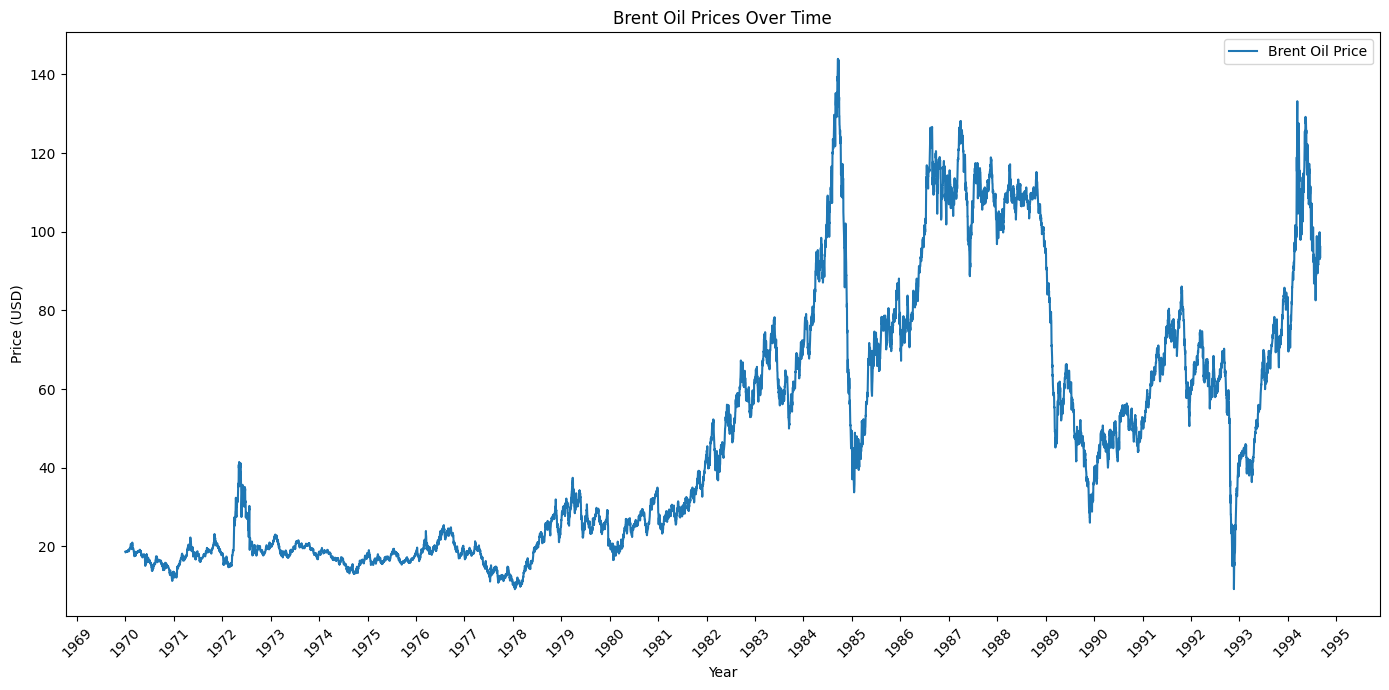

In [6]:
plt.figure(figsize=(14, 7))

# Plot the data
plt.plot(df.index, df['Price'], label='Brent Oil Price')

# Set the date format on the x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format for the ticks

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices Over Time')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()

## Distribution of price

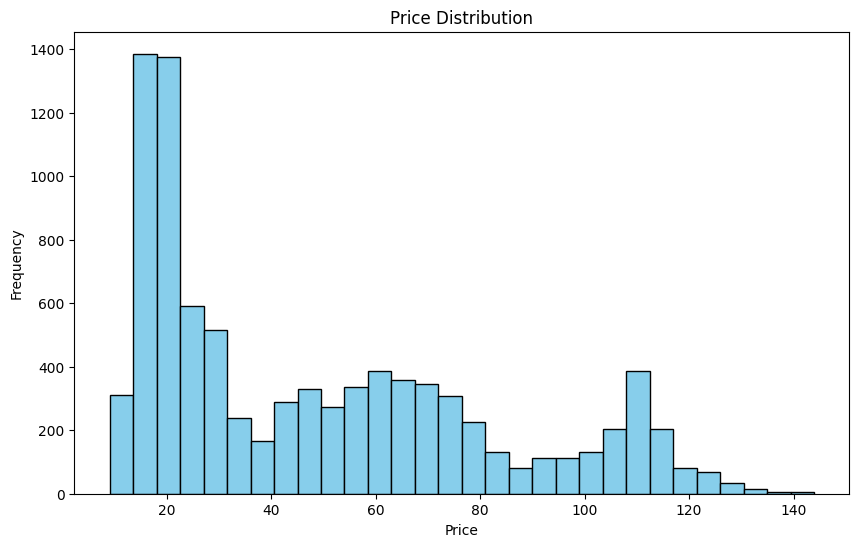

In [7]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### CUSUM (cumulative sum) method of Change Point Detection

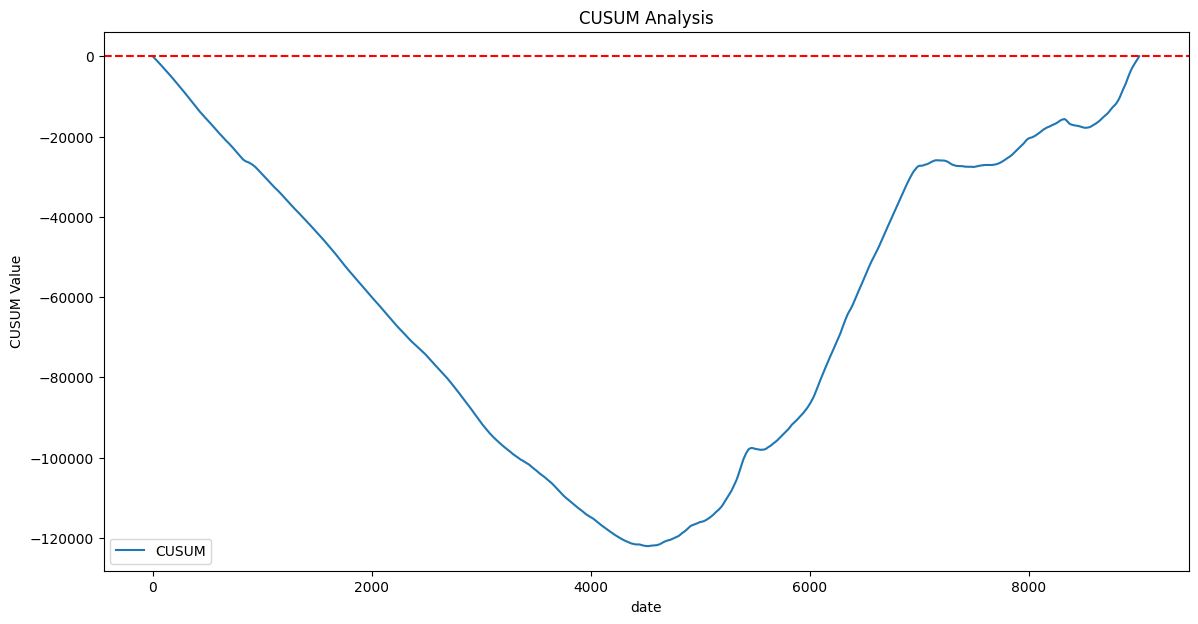

In [8]:
mean_price = df['Price'].mean()
cusum = np.cumsum(df['Price'] - mean_price)
plt.figure(figsize=(14, 7))
plt.plot(df.index, cusum, label='CUSUM')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('date')
plt.ylabel('CUSUM Value')
plt.title('CUSUM Analysis')
plt.legend()
plt.show()

## Brent Oil Prices with Detected Change Points

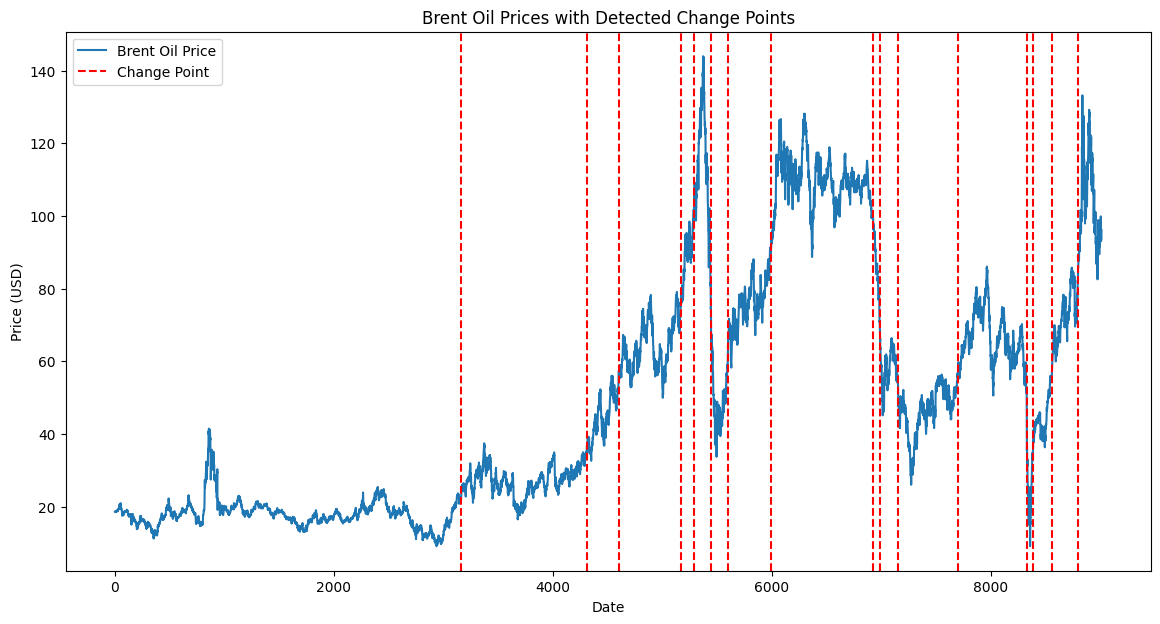

In [9]:
price_array = df['Price'].values
model = "rbf"
algo = rpt.Pelt(model=model).fit(price_array)
change_points = algo.predict(pen=20)

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
for cp in change_points[:-1]:
    plt.axvline(x=df.index[cp], color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Brent Oil Prices with Detected Change Points')
plt.legend()
plt.show()